# Training Deep Neural Networks on a GPU with PyTorch

### Part 4 of "Deep Learning with Pytorch: Zero to GANs"

This tutorial series is a hands-on beginner-friendly introduction to deep learning using [PyTorch](https://pytorch.org), an open-source neural networks library. These tutorials take a practical and coding-focused approach. The best way to learn the material is to execute the code and experiment with it yourself. Check out the full series here:

1. [PyTorch Basics: Tensors & Gradients](https://jovian.ai/aakashns/01-pytorch-basics)
2. [Gradient Descent & Linear Regression](https://jovian.ai/aakashns/02-linear-regression)
3. [Working with Images & Logistic Regression](https://jovian.ai/aakashns/03-logistic-regression) 
4. [Training Deep Neural Networks on a GPU](https://jovian.ai/aakashns/04-feedforward-nn)
5. [Image Classification using Convolutional Neural Networks](https://jovian.ai/aakashns/05-cifar10-cnn)
6. [Data Augmentation, Regularization and ResNets](https://jovian.ai/aakashns/05b-cifar10-resnet)
7. [Generating Images using Generative Adversarial Networks](https://jovian.ai/aakashns/06b-anime-dcgan/)

 This tutorial covers the following topics:
 
 * Creating a deep neural network with hidden layers
 * Using a non-linear activation function
 * Using a GPU (when available) to speed up training
 * Experimenting with hyperparameters to improve the model

## Preparing the Data

In [the previous tutorial](https://jovian.ai/aakashns/03-logistic-regression), we trained a logistic regression model to identify handwritten digits from the MNIST dataset with an accuracy of around 86%. The dataset consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

We noticed that it's quite challenging to improve the accuracy of a logistic regression model beyond 87%, since the model assumes a linear relationship between pixel intensities and image labels. In this post, we'll try to improve upon it  using a *feed-forward neural network* which can capture non-linear relationships between inputs and targets.

Let's begin by installing and importing the required modules and classes from `torch`, `torchvision`, `numpy`, and `matplotlib`.

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

We can download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`. 

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

In [ ]:
image, label = dataset[0]
image.shape

torch.Size([1, 28, 28])

In [ ]:
image.permute(1, 2, 0).shape

torch.Size([28, 28, 1])

image.shape: torch.Size([1, 28, 28])
Label: 5


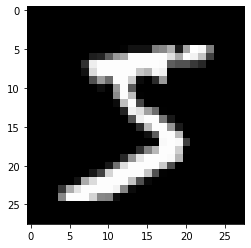

In [ ]:
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [ ]:
val_size = 10_000
train_size = len(dataset) -val_size
train_size

50000

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [ ]:
batch_size = 128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True )

Can you figure out the purpose of the arguments `num_workers` and `pin_memory`? Try looking into the documentation: https://pytorch.org/docs/stable/data.html .

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

images.shape: torch.Size([128, 1, 28, 28])


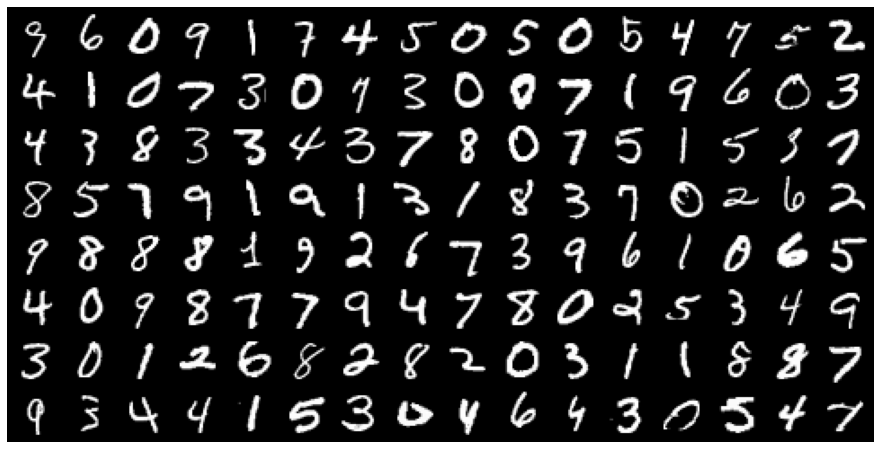

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a _hidden layer_ and an _output layer_. Additionally, we'll use an _activation function_ between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [ ]:
for images, labels in train_loader:
    print(f'images.shape : {images.shape}')
    inputs = images.reshape(-1, 784)
    print(f'inputs.shape: {inputs.shape}')
    break

images.shape : torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our _hidden_ layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the _learning capacity_ of the model.

In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32

In [ ]:
layer1 =  nn. Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

In [ ]:
inputs.shape

torch.Size([128, 784])

In [ ]:
layer1_outputs = layer1(inputs)
print(f'layer1_outputs.shape: {layer1_outputs.shape}')

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias. We can verify this using `torch.allclose`. For a more detailed explanation, review the tutorial on [linear regression](https://jovian.ai/aakashns/02-linear-regression).

In [ ]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [ ]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [ ]:
F.relu(torch.tensor([[1,-1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values were replaced with 0.

In [ ]:
relu_outputs = F.relu(layer1_outputs)
print(f'min(layer1_outputs): {torch.min(layer1_outputs).item()}')
print(f'min(relu_outputs): {torch.min(relu_outputs).item()}')

min(layer1_outputs): -0.7753705382347107
min(relu_outputs): 0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [ ]:
output_size=10
layer2 = nn.Linear(hidden_size, output_size)

In [ ]:
layer2_outputs = layer2(relu_outputs)
layer2_outputs.shape

torch.Size([128, 10])

In [ ]:
inputs.shape

torch.Size([128, 784])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [ ]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3094, grad_fn=<NllLossBackward0>)

Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.

In [ ]:
# Expanded version of layer2 (F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1. weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [ ]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A _deep neural network_ is simply a neural network with one or more hidden layers. In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can _learn_ rich and complex non-linear relationships between inputs and targets. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

In [ ]:
# Same as layer2(layer1(input))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [ ]:
# Create a single layer to replace the two linear layer
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [ ]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [ ]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [ ]:
class MnistModel(nn.Module):
     """Feedfoward neural network with 1 hidden layer"""
     def __init__(self, in_size, hidden_size, out_size):
         super().__init__()
         # hidden layer
         self.linear1 = nn.Linear(in_size, hidden_size)
         # output layer
         self.linear2 = nn.Linear(hidden_size, out_size)
    
     def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

     def training_step(self, batch):
        images, labes = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
     def validation_step(self, batch):
         images, labels = batch
         out = self(images)
         loss = F.cross_entropy(out, labels)
         acc = accuracy(out, labels)
         return {'val_loss': loss, 'val_acc': acc}

     def validation_epoch_end(self, outputs):
         batch_losses = [x['val_loss'] for x in outputs]
         epoch_loss = torch.stack(batch_losses).mean() # Combine losses
         batch_accs = [x['val_acc'] for x in outputs] 
         epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies
         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()} 

     def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

We'll create a model that contains a hidden layer with 32 activations.

In [ ]:
inputs_size = 784
hidden_size = 32 
num_classes = 10

In [ ]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print(f'Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.317092180252075
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0381, -0.0813, -0.1180,  0.0493, -0.0464, -0.1395,  0.0501, -0.0710,
         -0.1699,  0.0486],
        [-0.0334, -0.1322, -0.0575,  0.0223, -0.0151, -0.1092,  0.1021, -0.1283,
         -0.1841,  0.0377]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.